In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from cost_func import compute_acp_cost, overall_acp_cost
from reward_func import compute_reward_smooth
from model import WorldModel

DATA_PATH = "/abiomed/downsampled/10min_1hr_window.pkl"
#this is just for the visualization so it isn't messy
MAX_STEPS_TO_PLOT = 2000

In [2]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)
#this is a check to see what is included in the pkl file and hoow many episodes
print(f"there are {list(data.keys())} keys in dataset")
episodes = data['test']
print(f"episodes: {len(episodes)}")

there are ['train', 'val', 'test', 'mean', 'std'] keys in dataset
episodes: 1266


In [3]:
#to numpy if tensor
if isinstance(episodes, torch.Tensor):    
    episodes_np = episodes.numpy()  
else:
    episodes_np = np.array(episodes)

In [4]:
actions_all = episodes_np[:, :, -1]

#note that calling the functions in cost_func.py would not be applicable as we do not have a list of action lists
flattened_actions = actions_all.flatten()
flattened_acp = [np.linalg.norm(flattened_actions[i] - flattened_actions[i-1]) 
                 for i in range(1, len(flattened_actions))]

acp_per_timestep = np.mean(flattened_acp) 
print(f"Mean ACP per timestep accounting for between episodes: {acp_per_timestep:.6f}")


Mean ACP per timestep accounting for between episodes: 0.051478


In [9]:
all_steps_np = np.concatenate(episodes_np, axis=0)
total_steps_available = all_steps_np.shape[0]
print(f"Total timesteps: {total_steps_available}")

# Group the data in bins with 24 steps
episode_length = 24
num_bins = total_steps_available // episode_length
#creates bins and fits the samples into 3D
binned_steps = all_steps_np[:num_bins * episode_length].reshape(num_bins, episode_length, -1)
print(f"Created {num_bins} bins with {episode_length} steps")
# Randomly select 100 of these bins
num_episodes_to_sample = 633
#no replacement
sampled_bin_indices = np.random.choice(num_bins, num_episodes_to_sample, replace=False)

all_episode_rewards = []

# Loop through the 100 randomly selected bins
for bin_idx in sampled_bin_indices:
    # Get one bin
    episode_bin = binned_steps[bin_idx]
    
    normalized_rewards_for_episode = []
    # Loop through each of the 24 steps in the bin
    for step_data in episode_bin:
        step_tensor = torch.tensor(step_data, dtype=torch.float32)
        raw_reward = compute_reward_smooth(step_tensor.unsqueeze(0))
        
        # Apply normalization from rl_env
        norm_reward = (raw_reward + 4) / 5
        clipped_reward = np.clip(norm_reward, -1.0, 1.0)
        normalized_rewards_for_episode.append(clipped_reward)
    
    # Find the total reward for this simulated episode
    total_episode_reward = sum(normalized_rewards_for_episode)
    all_episode_rewards.append(total_episode_reward)

mean_total_episode_reward = np.mean(all_episode_rewards)

print(f"Mean total normalized reward per episode from 100 bins: {mean_total_episode_reward:.6f}")


Total timesteps: 15192
Created 633 bins with 24 steps
Mean total normalized reward per episode from 100 bins: -1.770329


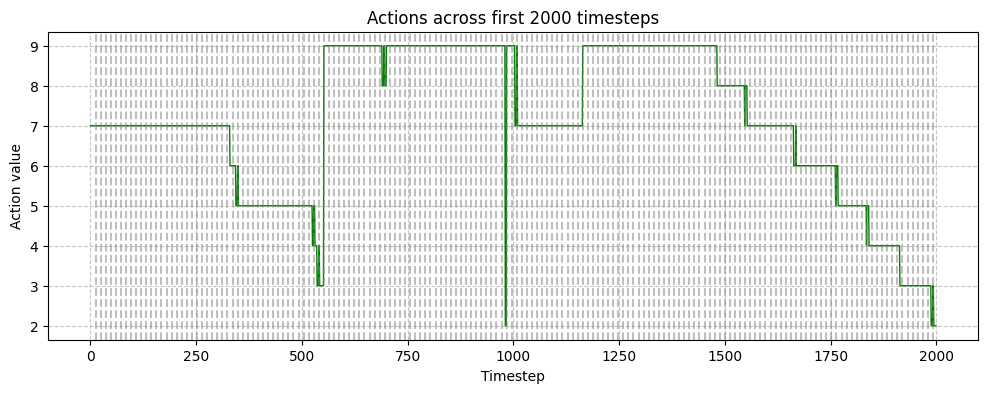

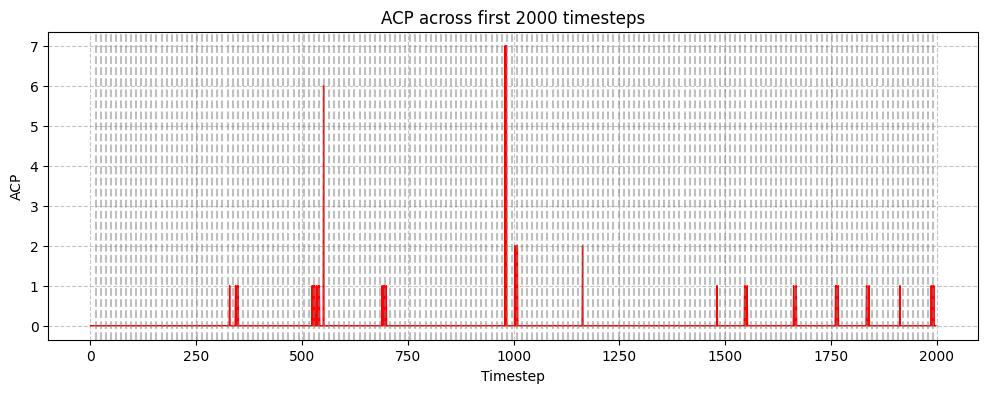

In [6]:
#acp will always have one less step
flattened_actions = flattened_actions[:MAX_STEPS_TO_PLOT]
flattened_acp = flattened_acp[:MAX_STEPS_TO_PLOT-1]
episode_lengths = [len(ep) for ep in actions_all]
episode_boundaries = np.cumsum(episode_lengths)
episode_boundaries = episode_boundaries[episode_boundaries < MAX_STEPS_TO_PLOT]

#action graph over timesteps
#I was getting confused where to check for episode ends so there are vertical lines for those
plt.figure(figsize=(12, 4))
plt.plot(flattened_actions, color='green', linewidth=1)
for boundary in episode_boundaries:
    plt.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Action value")
plt.title("Actions across first 2000 timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#acp graph over timesteps
plt.figure(figsize=(12, 4))
plt.plot(flattened_acp, color='red', linewidth=1)
for boundary in episode_boundaries:
    plt.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("ACP")
plt.title("ACP across first 2000 timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()